In [ ]:
!pip install gplearn
!pip install yfinance==0.2.47

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.46
    Uninstalling yfinance-0.2.46:
      Successfully uninstalled yfinance-0.2.46


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, GRU, SimpleRNN, Conv1D, MaxPooling1D, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import nan
from tensorflow.keras.optimizers import Adam

In [ ]:
commbankdata = yf.download('CBA.AX', start='2015-01-01', end='2023-08-01')
commbankdata.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02 00:00:00+00:00,53.524410,85.277962,85.277962,84.661308,84.959686,949439
2015-01-05 00:00:00+00:00,53.655502,85.486832,85.775269,85.049202,85.238182,1351651
2015-01-06 00:00:00+00:00,53.249725,84.840332,85.337639,84.412651,84.641411,2477275
2015-01-07 00:00:00+00:00,53.131123,84.651360,85.029312,84.094376,84.850281,2127190
2015-01-08 00:00:00+00:00,53.305897,84.929848,85.188446,84.671249,85.079041,1997761


In [ ]:
commbankdata.isnull().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
def sgp_model(data, population_size, generation, tournament_size, stopping_criteria, p_crossover, p_subtree_mutation, p_hoist_mutation, p_point_mutation, parsimony_coefficient, max_samples):
  y_data = data['Close']
  x_data = data.drop(columns=['Close'])

  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

  model = SymbolicRegressor(
        population_size=population_size,
        generations=generation,
        tournament_size=tournament_size,
        stopping_criteria=stopping_criteria,
        p_crossover=p_crossover,
        p_subtree_mutation=p_subtree_mutation,
        p_hoist_mutation=p_hoist_mutation,
        p_point_mutation=p_point_mutation,
        parsimony_coefficient=parsimony_coefficient,
        max_samples=max_samples,
        verbose=1,
        random_state=42
    )

  model.fit(x_train, y_train)

  new_feature_train = model.predict(x_train)
  new_feature_test = model.predict(x_test)

  print('TrainMSE: ' + str(mean_squared_error(y_train, new_feature_train)))
  print('TestMSE: ' + str(mean_squared_error(y_test, new_feature_test)))

  best_expression = model._program

  print("Best symbolic expression:", best_expression)

  return new_feature_train, new_feature_test, x_train, x_test, y_train, y_test


In [ ]:
#{'population_size': 481, 'generations': 29, 'tournament_size': 15, 'stopping_criteria': 0.09027873824051826, 'p_crossover': 0.5073304086983355, 'p_subtree_mutation': 0.05073356531669943, 'p_hoist_mutation': 0.021019908877199917, 'p_point_mutation': 0.07574467126522175, 'parsimony_coefficient': 0.006867934587272639, 'max_samples': 0.9285106976354418}
new_feature_train, new_feature_test, x_train, x_test, y_train, y_test = sgp_model(commbankdata, 481, 29, 15, 0.09027873824051826, 0.5073304086983355, 0.05073356531669943, 0.021019908877199917, 0.07574467126522175, 0.006867934587272639, 0.9285106976354418)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.48      7.57864e+27        7         0.402271         0.382738     15.68s
   1     9.22      2.36785e+10        7         0.395143         0.474609     11.61s
   2     6.45      6.77096e+06        5         0.295352         0.282189     10.81s
   3     3.76           103070        5         0.291555         0.331122     21.53s
   4     3.42           419357        5         0.288673         0.368275     14.06s
   5     4.98      1.06126e+06        5         0.286813         0.392238     14.78s
   6     5.11      1.56246e+12        5         0.287552         0.382722     16.39s
   7     5.17           962008        5         0.287246         0.386667      9.57s
   8     5.18      3.07808e+09        5         0.287617          0.38188  

In [ ]:
new_x_train = np.concatenate((x_train, new_feature_train.reshape(-1, 1)), axis=1)
new_x_test = np.concatenate((x_test, new_feature_test.reshape(-1, 1)), axis=1)

In [ ]:
x_train_temp = pd.DataFrame(new_x_train)
x_train_temp.columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'New Features']

x_test_temp = pd.DataFrame(new_x_test)
x_test_temp.columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'New Features']

x_data_temp = pd.concat([x_train_temp, x_test_temp])
y_data_temp = pd.concat([y_train, y_test])

In [ ]:
x_data_temp = x_data_temp.reset_index(drop=True)
y_data_temp = y_data_temp.reset_index(drop=True)

enhance_data = pd.concat([x_data_temp, y_data_temp], axis=1)
enhance_data = pd.DataFrame(enhance_data)

new_column_order = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'New Features']

enhance_data = enhance_data[new_column_order]
enhance_data

,Open,High,Low,Close,Adj Close,Volume,New Features
0,49.509640,73.315002,71.599998,73.099998,71.720001,4109344.0,73.195000
1,90.109810,97.000000,95.690002,95.690002,96.750000,2178339.0,95.940002
2,53.524410,85.277962,84.661308,85.277962,84.959686,949439.0,84.979584
3,93.021126,103.870003,102.559998,103.000000,103.680000,1758440.0,102.750000
4,58.470024,80.620003,79.160004,79.550003,80.449997,3543830.0,79.330009
...,...,...,...,...,...,...,...
2166,59.976650,75.239998,74.290001,74.940002,74.470001,1621358.0,75.059998
2167,69.743355,84.860001,84.160004,84.610001,84.440002,1877335.0,84.580002
2168,52.523567,77.970001,77.320000,77.550003,77.379997,1978433.0,77.910004
2169,65.266838,82.110001,81.510002,81.550003,81.900002,2316067.0,81.720001


In [ ]:
table1 = commbankdata.copy()
table2 = enhance_data.copy()

table1['New Features'] = nan

for idx1, row1 in table1.iterrows():
    non_missing_mask = row1[row1.index != 'New Features'].notna()

    common_cols = non_missing_mask.index.intersection(table2.columns)
    matching_rows = table2.loc[(table2[common_cols] == row1[common_cols].values).all(axis=1)]

    if not matching_rows.empty:
        for col in table1.columns:
            if pd.isna(row1[col]):
                table1.at[idx1, col] = matching_rows.iloc[0][col]

In [ ]:
enhance_data = table1
enhance_data

,Adj Close,Close,High,Low,Open,Volume,New Features
Date,,,,,,,
2015-01-02 00:00:00+00:00,53.524410,85.277962,85.277962,84.661308,84.959686,949439,NaN
2015-01-05 00:00:00+00:00,53.655502,85.486832,85.775269,85.049202,85.238182,1351651,NaN
2015-01-06 00:00:00+00:00,53.249725,84.840332,85.337639,84.412651,84.641411,2477275,NaN
2015-01-07 00:00:00+00:00,53.131123,84.651360,85.029312,84.094376,84.850281,2127190,NaN
2015-01-08 00:00:00+00:00,53.305897,84.929848,85.188446,84.671249,85.079041,1997761,NaN
...,...,...,...,...,...,...,...
2023-07-25 00:00:00+00:00,98.123535,104.199997,104.400002,103.510002,104.400002,1520910,NaN
2023-07-26 00:00:00+00:00,98.876884,105.000000,105.769997,103.669998,103.930000,1631244,NaN
2023-07-27 00:00:00+00:00,100.317665,106.529999,107.089996,105.300003,105.400002,2544987,NaN


In [ ]:
def load_and_process_data(data, train_ratio=0.8, price_value='Close'):
    scalers = {}

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[price_value].values.reshape(-1, 1))
    scalers[price_value] = scaler

    PREDICTION_DAYS = 100
    scaled_data_train = []
    scaled_data_test = []

    scaled_data = scaled_data[:, 0]
    for x in range(PREDICTION_DAYS, len(scaled_data)):
        scaled_data_train.append(scaled_data[x - PREDICTION_DAYS:x])
        scaled_data_test.append(scaled_data[x])

    scaled_data_train = np.array(scaled_data_train)
    scaled_data_test = np.array(scaled_data_test)

    scaled_data_train = np.reshape(scaled_data_train, (scaled_data_train.shape[0], scaled_data_train.shape[1], 1))

    train_size = int(len(scaled_data_train) * train_ratio)
    x_train, x_test = scaled_data_train[:train_size], scaled_data_train[train_size:]
    y_train, y_test = scaled_data_test[:train_size], scaled_data_test[train_size:]


    return x_train, y_train, x_test, y_test, scalers, scaler

In [ ]:
enhance_x_train, enhance_y_train, enhance_x_test, enhance_y_test, scalers, scaler = load_and_process_data(
    data=enhance_data,
    price_value='Close',
    train_ratio=0.8
)

print(enhance_x_train.shape)
print(enhance_y_train.shape)
print(enhance_x_test.shape)
print(enhance_y_test.shape)

(1656, 100, 1)
(1656,)
(415, 100, 1)
(415,)


In [ ]:
x_train, y_train, x_test, y_test, scalers, scaler = load_and_process_data(
    data=commbankdata,
    price_value='Close',
    train_ratio=0.8
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1656, 100, 1)
(1656,)
(415, 100, 1)
(415,)


In [ ]:
def lstm_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,1], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model.add(LSTM(units=units[0], return_sequences=True, activation=activations[0],input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(dropout))

  for i in range(n_layers - 3):
    model.add(LSTM(units=units[i+1], return_sequences=True, activation=activations[i+1]))
    model.add(Dropout(dropout))

  model.add(LSTM(units=units[-2], activation=activations[-2]))
  model.add(Dropout(dropout))

  model.add(Dense(units=units[-1], activation=activations[-1]))

  model.compile(optimizer=optimizer, loss=loss)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)

  return model

def gru_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,50], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model.add(GRU(units=units[0], return_sequences=True, activation=activations[0], input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(dropout))


  for i in range(n_layers - 3):
    model.add(GRU(units=units[i+1], return_sequences=True, activation=activations[i+1]))
    model.add(Dropout(dropout))

  model.add(GRU(units=units[-2], activation=activations[-2]))
  model.add(Dropout(dropout))
  model.add(Dense(units=units[-1], activation=activations[-1]))

  model.compile(optimizer=optimizer, loss=loss)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)
  return model

def rnn_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,50], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
    model.add(SimpleRNN(units=units[0], return_sequences=True, activation=activations[0], input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout))

    for i in range(n_layers - 3):
        model.add(SimpleRNN(units=units[i+1], return_sequences=True, activation=activations[i+1]))
        model.add(Dropout(dropout))

    model.add(SimpleRNN(units=units[-1], activation=activations[-2]))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation=activations[-1]))

    model.compile(optimizer=optimizer, loss=loss)
    model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)

    return model


def model_load(x_train, y_train, modelName='LSTM', epoch=25, batchSize=32, layers=4, dropout=0.2, units=[50,50,50,1], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model = Sequential()
  if layers != len(units) != len(activations):
    print('Number of layers and units and activation function do not match')
    return None

  if modelName == 'LSTM':
    return lstm_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  elif modelName == 'GRU':
    return gru_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  elif modelName == 'RNN':
    return rnn_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  else:
    print('Invalid model name')
    return None


In [ ]:
def hybrid_sgp_cnn_lstm(filters, kernel_size, pool_size, lstm_units, lr, n_layers, epochs, batchSize):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(enhance_x_train.shape[1], 1)))

    for i in range(n_layers):
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=(i < n_layers - 1))))
        if i < n_layers - 1:
            model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    history = model.fit(enhance_x_train, enhance_y_train,
                        epochs=epochs, batch_size=batchSize, verbose=1)
    return model, history


In [ ]:
# Best parameters for auto sgp:  {'filters': 27, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 64, 'learning_rate': 0.005466970330328919, 'n_layers': 1, 'epochs': 34, 'batch_size': 64}
# Best parameters for normal sgp:  {'filters': 80, 'kernel_size': 4, 'pool_size': 3, 'lstm_units': 128, 'learning_rate': 0.0022144175034163062, 'n_layers': 1, 'epochs': 33, 'batch_size': 64}
hybrid_model, history = hybrid_sgp_cnn_lstm(80, 4, 3, 128, 0.0022144175034163062, 1, 33, 64)

Epoch 1/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - loss: 0.0469 - mae: 0.1488
Epoch 2/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - loss: 0.0023 - mae: 0.0364
Epoch 3/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - loss: 0.0011 - mae: 0.0236
Epoch 4/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 422ms/step - loss: 8.5525e-04 - mae: 0.0213
Epoch 5/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - loss: 7.8451e-04 - mae: 0.0215
Epoch 6/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - loss: 8.1655e-04 - mae: 0.0212
Epoch 7/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - loss: 7.1221e-04 - mae: 0.0196
Epoch 8/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - loss: 6.8387e-04 - mae: 0.0193
Epoch 9/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - loss: 6.4099e-04 - mae: 0.0191
Epoch 10/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - loss: 5.8658e-04 - mae: 0.0181
Epoch 11/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 340ms/step - loss: 5.5508e-04 - mae: 0.0171
Epoch 12/33
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - loss: 5.33

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
R-squared on training set: 0.98
MAPE on training set: 264778651044.53


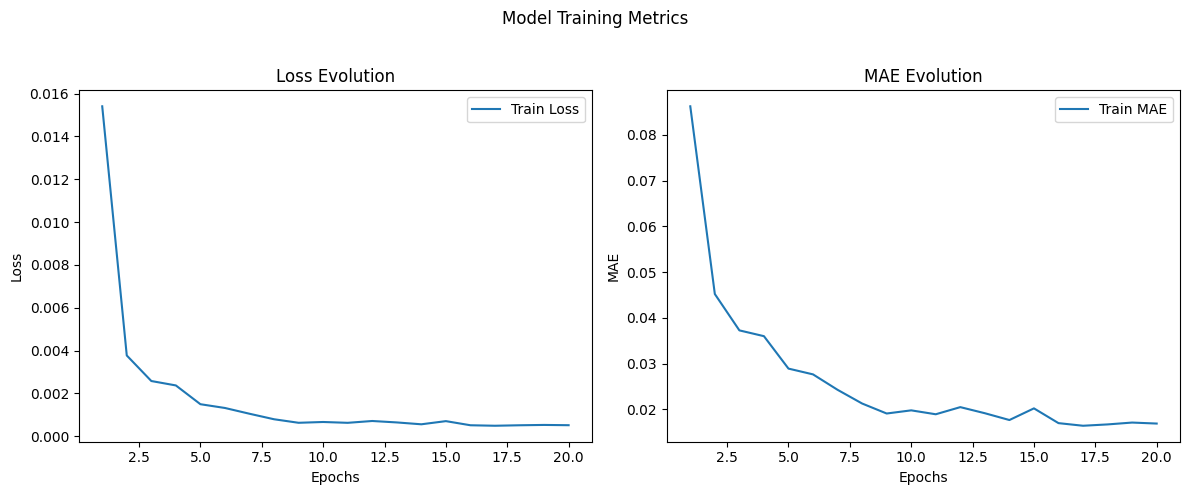

In [ ]:
# Extract metrics from history
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
train_mae = history.history['mae']

y_pred = hybrid_model.predict(enhance_x_train)
r2 = r2_score(enhance_y_train, y_pred)

print(f'R-squared on training set: {r2:.2f}')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Model Training Metrics')

# Loss plot
axs[0].plot(epochs, train_loss, label='Train Loss')
axs[0].set_title('Loss Evolution')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MAE plot
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].set_title('MAE Evolution')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Display the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
sgp_lstm_model = model_load(enhance_x_train, enhance_y_train, 'LSTM', 25, 32, 4, 0.2, [128,64,32,1], ['relu', 'relu', 'relu','linear'], 'adam', 'mean_squared_error')

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - loss: 0.0957
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - loss: 0.0100
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - loss: 0.0074
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - loss: 0.0071
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 0.0069
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - loss: 0.0058
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - loss: 0.0054
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - loss: 0.0048
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - loss: 0.0050
Epoch 10/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - loss: 0.0056
Epoch 11/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - loss: 0.0049
Epoch 12/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - loss: 0.0048
Epoch 13/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - loss: 0.0047
Epoch 14/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - loss: 0.0041
Epoch 15/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step 

In [ ]:
normal_lstm_model = model_load(x_train, y_train, 'LSTM', 25, 32, 4, 0.2, [128,64,32,1], ['relu', 'relu', 'relu','linear'], 'adam', 'mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - loss: 0.1024
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - loss: 0.0096
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.0078
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - loss: 0.0070
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 332ms/step - loss: 0.0061
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - loss: 0.0057
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - loss: 0.0052
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - loss: 0.0054
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - loss: 0.0049
Epoch 10/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: 0.0045
Epoch 11/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - loss: 0.0055
Epoch 12/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.0049
Epoch 13/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - loss: 0.0044
Epoch 14/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.0042
Epoch 15/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 

In [ ]:
gru_model = model_load(x_train, y_train, 'GRU', 25, 32, 4, 0.2, [128,64,32,1], ['relu', 'relu', 'relu','linear'], 'adam', 'mean_squared_error')

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - loss: 0.0936
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - loss: 0.0087
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - loss: 0.0067
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - loss: 0.0053
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - loss: 0.0057
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 0.0051
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - loss: 0.0054
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - loss: 0.0045
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - loss: 0.0042
Epoch 10/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 0.0045
Epoch 11/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 0.0042
Epoch 12/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - loss: 0.0044
Epoch 13/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: 0.0036
Epoch 14/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.0036
Epoch 15/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step 

In [ ]:
hybrid_predicted_prices = hybrid_model.predict(enhance_x_test)
print('MSE: ' + str(mean_squared_error(enhance_y_test, hybrid_predicted_prices)))
print('R2: ' + str(r2_score(enhance_y_test, hybrid_predicted_prices)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step
MSE: 0.0005413406077444901
R2: 0.9242861143861534


In [ ]:
enhance_predicted_prices = sgp_lstm_model.predict(enhance_x_test)
print('MSE: ' + str(mean_squared_error(enhance_y_test, enhance_predicted_prices)))
print('R2: ' + str(r2_score(enhance_y_test, enhance_predicted_prices)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
MSE: 0.0018886930718417234
R2: 0.7358404502538554


In [ ]:
normal_predicted_prices = normal_lstm_model.predict(x_test)
print('MSE: ' + str(mean_squared_error(y_test, normal_predicted_prices)))
print('R2: ' + str(r2_score(y_test, normal_predicted_prices)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step
MSE: 0.0015205477843241392
R2: 0.7873306022757396


In [ ]:
gru_preidcted_price = gru_model.predict(x_test)
print('MSE: ' + str(mean_squared_error(y_test, gru_preidcted_price)))
print('R2: ' + str(r2_score(y_test, gru_preidcted_price)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
MSE: 0.0022732959759402204
R2: 0.6820484755320713


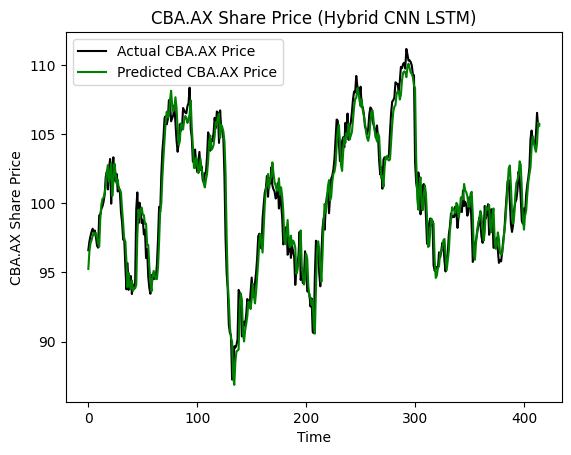

In [ ]:
hybrid_y_test = scalers['Close'].inverse_transform(enhance_y_test.reshape(-1, 1))
hybrid_predicted_prices = scaler.inverse_transform(hybrid_predicted_prices.reshape(-1,1))

plt.plot(hybrid_y_test, color="black", label=f"Actual {'CBA.AX'} Price")
plt.plot(hybrid_predicted_prices, color="green", label=f"Predicted {'CBA.AX'} Price")
plt.title(f"{'CBA.AX'} Share Price (Hybrid CNN LSTM)")
plt.xlabel("Time")
plt.ylabel(f"{'CBA.AX'} Share Price")
plt.legend()
plt.show()

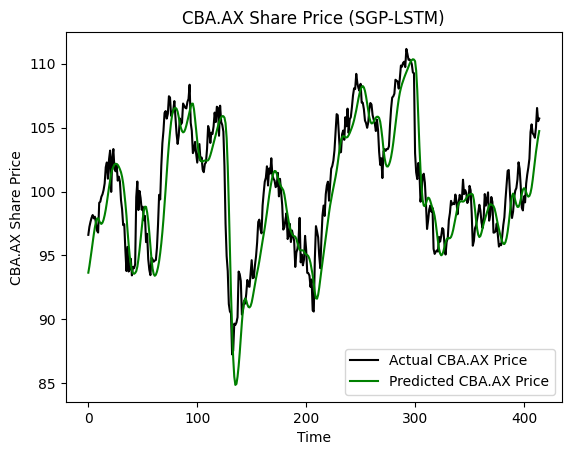

In [ ]:
enhance_y_test = scalers['Close'].inverse_transform(enhance_y_test.reshape(-1, 1))
enhance_predicted_prices = scaler.inverse_transform(enhance_predicted_prices.reshape(-1,1))

plt.plot(enhance_y_test, color="black", label=f"Actual {'CBA.AX'} Price")
plt.plot(enhance_predicted_prices, color="green", label=f"Predicted {'CBA.AX'} Price")
plt.title(f"{'CBA.AX'} Share Price (SGP-LSTM)")
plt.xlabel("Time")
plt.ylabel(f"{'CBA.AX'} Share Price")
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


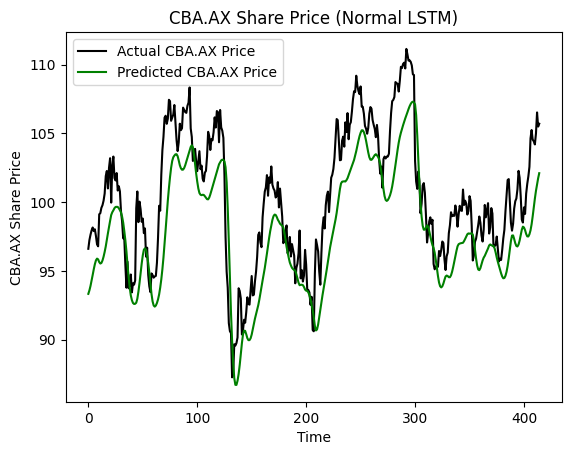

In [ ]:
y_test = scalers['Close'].inverse_transform(y_test.reshape(-1, 1))
normal_predicted_prices = scaler.inverse_transform(normal_predicted_prices.reshape(-1,1))

plt.plot(y_test, color="black", label=f"Actual {'CBA.AX'} Price")
plt.plot(normal_predicted_prices, color="green", label=f"Predicted {'CBA.AX'} Price")
plt.title(f"{'CBA.AX'} Share Price (Normal LSTM)")
plt.xlabel("Time")
plt.ylabel(f"{'CBA.AX'} Share Price")
plt.legend()
plt.show()

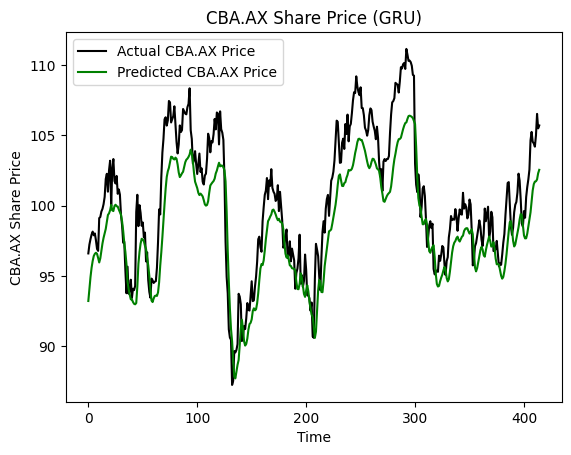

In [ ]:
y_test = scalers['Close'].inverse_transform(y_test.reshape(-1, 1))
gru_preidcted_price = scaler.inverse_transform(gru_preidcted_price.reshape(-1,1))

plt.plot(y_test, color="black", label=f"Actual {'CBA.AX'} Price")
plt.plot(gru_preidcted_price, color="green", label=f"Predicted {'CBA.AX'} Price")
plt.title(f"{'CBA.AX'} Share Price (GRU)")
plt.xlabel("Time")
plt.ylabel(f"{'CBA.AX'} Share Price")
plt.legend()
plt.show()